In [1]:
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from matplotlib.colors import LogNorm
from matplotlib import rc
from numpy import inf
import itertools
from os import listdir
import uproot
import awkward as ak
from sklearn.model_selection import train_test_split

import matplotlib as mpl

from datetime import datetime
import subprocess
from tensorflow.keras.layers import Input, Dense, Dropout, GlobalAveragePooling1D, GlobalMaxPooling1D
from tensorflow.keras.models import Model, Sequential
import os
import tensorflow as tf
import sys
import importlib
sys.path.append('/scratch/mjosef/Unfolding/omnifold')
from omnifold import DataLoader, MLP, SetStyle, HistRoutine, net, PET, omnifold
from of_transformer import block, embed, input_distributed, net_utils, of_transformer, pair_embed, sequence_trimmer 

from IPython.display import Image

os.environ['CUDA_VISIBLE_DEVICES']="2" #odslserv 0123 überprüfen
has_gpu=True

from pickle import dump

print(tf.config.list_physical_devices())

if has_gpu :
    os.environ['CUDA_VISIBLE_DEVICES']="3"
    physical_devices = tf.config.list_physical_devices('GPU') 
    for gpu in physical_devices:
        tf.config.experimental.set_memory_growth(gpu, True)

2025-10-02 09:51:11.219641: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-10-02 09:51:11.236430: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1759391471.251939 2263468 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1759391471.256879 2263468 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1759391471.270726 2263468 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

Horovod not found, will continue with single only GPUs.
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [2]:
TUnfold_incl_path = '/scratch/mjosef/OMNIFOLD_Tutorial/datasets/WbWb_files/bulk_region/unfolding_SR_Bulk_Final_l_4j_incl_TUnfoldStandalone_OptionA_data_nonClosureAlternative.root'
TUnfold_incl_file = uproot.open(TUnfold_incl_path)

In [4]:
#reco_herwig = '/scratch/mjosef/OMNIFOLD_Tutorial/datasets/WbWb_files/bulk_region/ttbar_enhanced_Herwig71_fast.Nominal.root'
#truth_pythia = '/scratch/mjosef/OMNIFOLD_Tutorial/datasets/WbWb_files/bulk_region/truth_ttbar_enhanced.Nominal.root'
#reco_pythia = '/scratch/mjosef/OMNIFOLD_Tutorial/datasets/WbWb_files/bulk_region/ttbar_enhanced.Nominal.root'
#
#
#herwig_file = uproot.open(reco_herwig)
#herwig_tree = herwig_file['NOSYS/4j_incl']
#
#pythia_truth_file = uproot.open(truth_pythia)
#pythia_truth_tree = pythia_truth_file['NOSYS/physics']
#
#pythia_reco_file = uproot.open(reco_pythia)
#pythia_reco_tree = pythia_reco_file['NOSYS/4j_incl']
#pythia_matched_tree = pythia_reco_file['NOSYS/matched_4j_incl']

#herwig_array = herwig_tree.arrays()
#pythia_array = pythia_tree.arrays()

pythia_df = pd.read_pickle('/scratch/mjosef/OMNIFOLD_Tutorial/datasets/WbWb_files/bulk_region/df_pythia_ttbar.pkl')
#herwig_df = pd.read_pickle('/scratch/mjosef/OMNIFOLD_Tutorial/datasets/WbWb_files/bulk_region/df_herwig_master.pkl')
data_df = pd.read_pickle('/scratch/mjosef/OMNIFOLD_Tutorial/datasets/WbWb_files/bulk_region/df_data.pkl')
pythia_df["w2"] = pythia_df['eventWeight'].to_numpy()*pythia_df['eventWeight'].to_numpy()
#herwig_df["w2"] = herwig_df['eventWeight'].to_numpy()*herwig_df['eventWeight'].to_numpy()
data_df.fillna(0.0, inplace=True)

In [5]:
def MC_data_shaper(df):

    particle_names = ['l1', 'b1', 'b2', 'b3', 'b4', 'j1', 'j2', 'j3', 'j4', 'j5', 'j6']

    # Build reco and truth arrays
    reco_pts  = [df[f'pt{p}']   for p in particle_names]
    reco_etas = [df[f'eta{p}']  for p in particle_names]
    reco_phis = [df[f'phi{p}']  for p in particle_names]
    
    # Masses: lepton = 0, b-jets = mb1–4, jets = mj1–6
    reco_masses = [np.zeros_like(df['ptl1'])] + \
                  [df[f'mb{i}'] for i in range(1, 5)] + \
                  [df[f'mj{i}'] for i in range(1, 7)]
    # Stack into (12 particles, n_events, 4)
    reco_features = np.stack([reco_pts, reco_etas, reco_phis, reco_masses], axis=-1)
    reco_features = reco_features.transpose(1, 0, 2)  # → (n_events, 12, 4)

    # Neutrino (reco): met, eta=0, phi=metphi, mass=0
    met_pt = df['met']
    met_phi = df['metphi']
    zeros = np.zeros_like(met_pt)
    neutrino_reco = np.stack([met_pt, zeros, met_phi, zeros], axis=-1)  # (n_events, 4)

    # Append neutrino
    reco_features = np.concatenate([reco_features, neutrino_reco[:, None, :]], axis=1)  # (n_events, 12, 4)
    truth_pts  = [df[f'truth_pt{p}']   for p in particle_names]
    truth_etas = [df[f'truth_eta{p}']  for p in particle_names]
    truth_phis = [df[f'truth_phi{p}']  for p in particle_names]
    
    truth_masses = [np.zeros_like(df['truth_ptl1'])] + \
                   [df[f'truth_mb{i}'] for i in range(1, 5)] + \
                   [df[f'truth_mj{i}'] for i in range(1, 7)]

    truth_features = np.stack([truth_pts, truth_etas, truth_phis, truth_masses], axis=-1)
    truth_features = truth_features.transpose(1, 0, 2)

    # Neutrino (truth): use 'truth_met' and 'truth_met_phi'
    truth_met_pt = df['truth_met']
    truth_met_phi = df['truth_metphi']
    zeros_truth = np.zeros_like(truth_met_pt)
    neutrino_truth = np.stack([truth_met_pt, zeros_truth, truth_met_phi, zeros_truth], axis=-1)

    truth_features = np.concatenate([truth_features, neutrino_truth[:, None, :]], axis=1)
    
    return reco_features, truth_features

def DATA_shaper(df):

    particle_names = ['l1', 'b1', 'b2', 'b3', 'b4', 'j1', 'j2', 'j3', 'j4', 'j5', 'j6']

    # Build reco and truth arrays
    reco_pts  = [df[f'pt{p}']   for p in particle_names]
    reco_etas = [df[f'eta{p}']  for p in particle_names]
    reco_phis = [df[f'phi{p}']  for p in particle_names]
    
    # Masses: lepton = 0, b-jets = mb1–4, jets = mj1–6
    reco_masses = [np.zeros_like(df['ptl1'])] + \
                  [df[f'mb{i}'] for i in range(1, 5)] + \
                  [df[f'mj{i}'] for i in range(1, 7)]
    # Stack into (12 particles, n_events, 4)
    reco_features = np.stack([reco_pts, reco_etas, reco_phis, reco_masses], axis=-1)
    reco_features = reco_features.transpose(1, 0, 2)  # → (n_events, 12, 4)

    # Neutrino (reco): met, eta=0, phi=metphi, mass=0
    met_pt = df['met']
    met_phi = df['metphi']
    zeros = np.zeros_like(met_pt)
    neutrino_reco = np.stack([met_pt, zeros, met_phi, zeros], axis=-1)  # (n_events, 4)

    # Append neutrino
    reco_features = np.concatenate([reco_features, neutrino_reco[:, None, :]], axis=1)  # (n_events, 12, 4)
    
    return reco_features

In [6]:
pythia_reco, pythia_truth = MC_data_shaper(pythia_df)
#herwig_reco, herwig_truth = MC_data_shaper(herwig_df)
data_array = DATA_shaper(data_df)

pythia_weights = pythia_df['eventWeight'].to_numpy()
#herwig_weights = herwig_df['eventWeight'].to_numpy()
data_weights = data_df['eventWeight'].to_numpy()

pythia_pass_reco = pythia_df['pass_reco'].to_numpy()
pythia_pass_gen = pythia_df['pass_particle'].to_numpy()

In [7]:
all_indices_pythia = np.arange(len(pythia_reco))
np.random.seed(42)  # reproducibility
np.random.shuffle(all_indices_pythia)

# First random sample
random_indices_pythia_1 = all_indices_pythia[:1_000_000]
# Second, independent (non-overlapping) sample
random_indices_pythia_2 = all_indices_pythia[1_000_000:2_000_000]

# First Pythia sample
pythia_reco_train    = pythia_reco[random_indices_pythia_1]
pythia_truth_train   = pythia_truth[random_indices_pythia_1]
pythia_weights_train = pythia_weights[random_indices_pythia_1]
pythia_pass_reco_train = pythia_pass_reco[random_indices_pythia_1]
pythia_pass_gen_train = pythia_pass_gen[random_indices_pythia_1]

# Second Pythia sample
pythia_reco_test    = pythia_reco[random_indices_pythia_2]
pythia_truth_test   = pythia_truth[random_indices_pythia_2]
pythia_weights_test = pythia_weights[random_indices_pythia_2]
pythia_pass_reco_test = pythia_pass_reco[random_indices_pythia_2]
pythia_pass_gen_test = pythia_pass_gen[random_indices_pythia_2]

# First Herwig sample
#random_indices_herwig = np.random.choice(len(herwig_reco), size=1_000_000, replace=False)
#herwig_reco_train   = herwig_reco[random_indices_herwig]
#herwig_truth_train   = herwig_truth[random_indices_herwig]
#herwig_weights_train = herwig_weights[random_indices_herwig]

In [8]:
#herwig_loader = DataLoader(reco = herwig_reco_train, gen = herwig_truth_train, weight = herwig_weights_train,
#                           normalize=True, normalization_factor = np.sum(herwig_weights_train))
#
pythia_loader = DataLoader(reco = pythia_reco_train, gen = pythia_truth_train, weight = pythia_weights_train,
                           pass_reco = pythia_pass_reco_train, pass_gen = pythia_pass_gen_train,
                           normalize=True, normalization_factor = np.sum(pythia_weights_train))
data_loader = DataLoader(reco = data_array[:1_000_000], weight = data_weights[:1_000_000],
                       normalize=True, normalization_factor = np.sum(data_weights[:1_000_000]))

INFO: Normalizing sum of weights to 59506.36328125 ...
INFO: Creating pass reco flag ...
INFO: Normalizing sum of weights to 1000000.0 ...


In [9]:
train_fraction = len(pythia_truth_train)/len(pythia_df)
print("Train fraction:", train_fraction)

Train fraction: 0.0051912252988716885


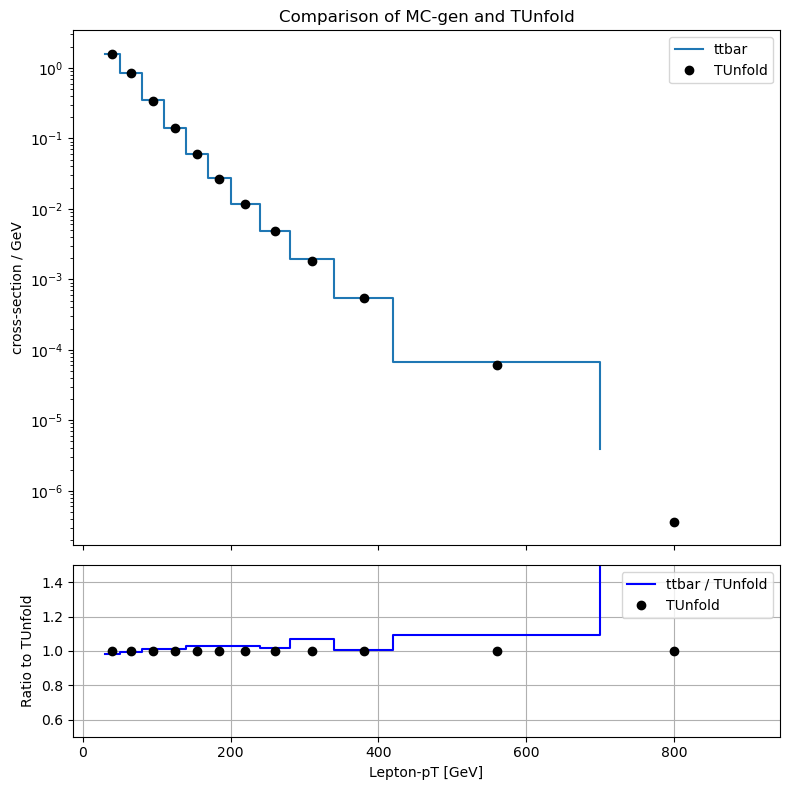

In [10]:
luminosity = 3244.54 + 33402.2 + 44630.6 + 58791.6
SF = (1/luminosity)*1/train_fraction

fig, (ax1, ax2) = plt.subplots(
    2, 1, 
    figsize=(8, 8), 
    gridspec_kw={'height_ratios': [3, 1]}, 
    sharex=True
)

# --- Bin widths (same for all histograms) ---
bin_widths = np.diff(edges)

# --- Upper panel: your histograms ---
counts1, bins1, _ = ax1.hist(
    pythia_loader.gen[:, 0, 0][pythia_loader.pass_gen], 
    weights=pythia_loader.weight[pythia_loader.pass_gen]*SF, 
    bins=edges, 
    histtype='step', 
    label='ttbar'
)

# Normalize counts by bin width
counts1_density = counts1 / bin_widths
values_density = values / bin_widths
bin_centers = 0.5 * (edges[:-1] + edges[1:])
# Re-plot them stepwise
ax1.cla()
ax1.step(edges[:-1], counts1_density, where="post", label="ttbar")
ax1.plot(bin_centers, values_density, 'o', color='black', label='TUnfold')
#ax1.step(edges[:-1], values_density, where="post", label="TUnfold")

ax1.set_ylabel("cross-section / GeV")
ax1.set_title("Comparison of MC-gen and TUnfold")
ax1.legend()
ax1.set_yscale('log')

# --- Lower panel: ratio ---
# Avoid division by zero
ratio1 = np.divide(counts1_density, values_density, out=np.zeros_like(counts1_density), where=values_density!=0)
ratio3 = np.ones_like(values_density)  # TUnfold / TUnfold



# Step style ratios
ratio1_step = np.append(ratio1, ratio1[-1])

ax2.step(edges, ratio1_step, where="post", color="blue", label="ttbar / TUnfold")
ax2.plot(bin_centers, ratio3, 'o', color='black', label='TUnfold')

#ax2.axhline(1.0, color='red', linestyle='--')

ax2.set_xlabel("Lepton-pT [GeV]")
ax2.set_ylabel("Ratio to TUnfold")
ax2.set_ylim(0.5, 1.5)
ax2.legend()
ax2.grid()

plt.tight_layout()
plt.show()

In [10]:
def make_mc_subsample(loader, reco_cuts_mask, N_data):
    """
    Erzeuge ein MC-Subsample mit gleicher statistischer Genauigkeit wie die Daten.

    Parameters
    ----------
    loader : DataLoader
        DataLoader-Objekt mit Attributen `.reco`, `.gen`, `.weight`
    reco_cuts_mask : np.ndarray(bool)
        Maske der Events, die die Reco-Level-Cuts bestehen (analog zu den Daten)
    N_data : int
        Anzahl an Daten-Events, die die Reco-Level-Cuts bestehen
    """

    # Gesamtanzahl an MC-Events
    n_events = len(loader.weight)

    # Init: alle Flags auf False
    flags = np.zeros(n_events, dtype=bool)

    # Summen
    sum_w = 0.0
    sum_w2 = 0.0

    # Ziel-Statistik (Daten haben alle w=1)
    target_rel_unc = 1.0 / np.sqrt(N_data)

    # Loop über Events
    for idx in range(n_events):
        if not reco_cuts_mask[idx]:
            continue

        w = loader.weight[idx]
        sum_w += w
        sum_w2 += w**2

        flags[idx] = True  # Event geht ins Subsample

        # relative Unsicherheit bisher
        rel_unc = np.sqrt(sum_w2) / sum_w

        if rel_unc < target_rel_unc:
            break

    return flags

In [11]:
flags_mc = make_mc_subsample(
    pythia_loader,
    reco_cuts_mask=pythia_loader.pass_reco,
    N_data=np.sum(data_loader.weight)
)

In [12]:
import tensorflow as tf
from tensorflow.keras import layers, Model, Input

class MaskedAveragePooling(layers.Layer):
    def call(self, x, mask):
        # x: (batch, seq_len, features)
        # mask: (batch, seq_len), dtype bool
        mask = tf.cast(mask, tf.float32)[..., tf.newaxis]  # (batch, seq_len, 1)
        x = x * mask
        return tf.reduce_sum(x, axis=1) / tf.reduce_sum(mask, axis=1)

class ParticleMaskLayer(layers.Layer):
    def call(self, x):
        return tf.reduce_any(tf.not_equal(x, 0), axis=-1)  # shape: (batch, seq)

def build_transformer_model(input_shape=(12, 4),
                            num_heads=4,
                            ff_dim=64,
                            num_transformer_blocks=2,
                            dropout_rate=0.1):

    inputs = Input(shape=input_shape)

    # Get attention mask: True where not padded
    mask = ParticleMaskLayer()(inputs)  # shape: (batch, 11)

    # Learned positional embedding
    positions = tf.range(start=0, limit=input_shape[0], delta=1)
    pos_embed = layers.Embedding(input_dim=input_shape[0], output_dim=input_shape[1])(positions)
    x = inputs + pos_embed  # broadcasting position embedding

    for _ in range(num_transformer_blocks):
        attn_output = layers.MultiHeadAttention(
            num_heads=num_heads,
            key_dim=input_shape[1]
        )(x, x, attention_mask=mask[:, tf.newaxis, :])  # shape: (batch, 1, 11)

        attn_output = layers.Dropout(dropout_rate)(attn_output)
        x = layers.LayerNormalization(epsilon=1e-6)(x + attn_output)

        ff_output = layers.Dense(ff_dim, activation='relu')(x)
        ff_output = layers.Dense(input_shape[1])(ff_output)
        ff_output = layers.Dropout(dropout_rate)(ff_output)
        x = layers.LayerNormalization(epsilon=1e-6)(x + ff_output)

    # Use masked average pooling instead of GlobalAveragePooling1D
    x = MaskedAveragePooling()(x, mask)

    x = layers.Dense(64, activation='relu')(x)
    x = layers.Dropout(dropout_rate)(x)
    outputs = layers.Dense(1, activation='sigmoid')(x)

    return Model(inputs=inputs, outputs=outputs)

In [13]:
model1 = build_transformer_model()
model2 = build_transformer_model()

I0000 00:00:1759391994.246262 2263468 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 137784 MB memory:  -> device: 0, name: NVIDIA H200, pci bus id: 0000:43:00.0, compute capability: 9.0


In [40]:
importlib.reload(omnifold)

Horovod not found, will continue with single only GPUs.


<module 'omnifold.omnifold' from '/scratch/mjosef/Unfolding/omnifold/omnifold/omnifold.py'>

In [14]:
omnifold = omnifold.MultiFold(
    "WWbb_transformer_real-data",
    model1,
    model2,
    data_loader,
    pythia_loader,
    batch_size = 128,
    niter = 4,  #Number of Iterations                                                                                                                                                                                                  
    epochs=100,     
    weights_folder = '/scratch/mjosef/Unfolding/omnifold/weights_real-data',
    verbose = True,
    lr = 1e-6,
    early_stop=5,
    n_ensemble=3,
)

15625 training steps at reco and 15625 steps at gen


In [15]:
%%time
omnifold.Unfold()

ITERATION: 1
RUNNING STEP 1
Creating cached data from step 1
################################################################################
Train events used: 820708, Test events used: 205177
################################################################################
Ensemble: 1 / 3
Epoch 1/100


I0000 00:00:1759306767.861166 3435328 service.cc:152] XLA service 0x7f0c1c0155d0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1759306767.861200 3435328 service.cc:160]   StreamExecutor device (0): NVIDIA H200, Compute Capability 9.0
2025-10-01 10:19:27.999559: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1759306768.840862 3435328 cuda_dnn.cc:529] Loaded cuDNN version 90501


  45/5129 ━━━━━━━━━━━━━━━━━━━━ 18s 4ms/step - loss: 0.4543 

I0000 00:00:1759306776.388453 3435328 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


5129/5129 ━━━━━━━━━━━━━━━━━━━━ 36s 4ms/step - loss: 0.4433 - val_loss: 0.4023 - learning_rate: 1.0000e-06
Epoch 2/100
5129/5129 ━━━━━━━━━━━━━━━━━━━━ 22s 4ms/step - loss: 0.3929 - val_loss: 0.3661 - learning_rate: 1.0000e-06
Epoch 3/100
5129/5129 ━━━━━━━━━━━━━━━━━━━━ 22s 4ms/step - loss: 0.3629 - val_loss: 0.3480 - learning_rate: 1.0000e-06
Epoch 4/100
5129/5129 ━━━━━━━━━━━━━━━━━━━━ 23s 4ms/step - loss: 0.3464 - val_loss: 0.3374 - learning_rate: 1.0000e-06
Epoch 5/100
5129/5129 ━━━━━━━━━━━━━━━━━━━━ 21s 4ms/step - loss: 0.3367 - val_loss: 0.3311 - learning_rate: 1.0000e-06
Epoch 6/100
5129/5129 ━━━━━━━━━━━━━━━━━━━━ 22s 4ms/step - loss: 0.3307 - val_loss: 0.3264 - learning_rate: 1.0000e-06
Epoch 7/100
5129/5129 ━━━━━━━━━━━━━━━━━━━━ 21s 4ms/step - loss: 0.3260 - val_loss: 0.3225 - learning_rate: 1.0000e-06
Epoch 8/100
5129/5129 ━━━━━━━━━━━━━━━━━━━━ 20s 4ms/step - loss: 0.3223 - val_loss: 0.3193 - learning_rate: 1.0000e-06
Epoch 9/100
5129/5129 ━━━━━━━━━━━━━━━━━━━━ 20s 4ms/step - loss: 0.31

In [16]:
unfolded_weights  = omnifold.reweight(pythia_truth_test,omnifold.model2,batch_size=1000)

Averaging over ensembles...
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step  
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 998us/step
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 922us/step


In [17]:
np.save("/scratch/mjosef/Unfolding/omnifold/weights_real-data/unfolded_weights.npy", unfolded_weights)

In [15]:
unfolded_weights = np.load("/scratch/mjosef/Unfolding/omnifold/weights_real-data/unfolded_weights.npy")

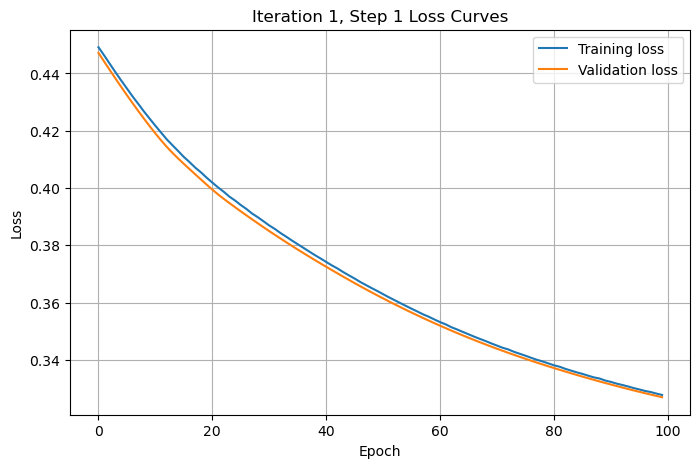

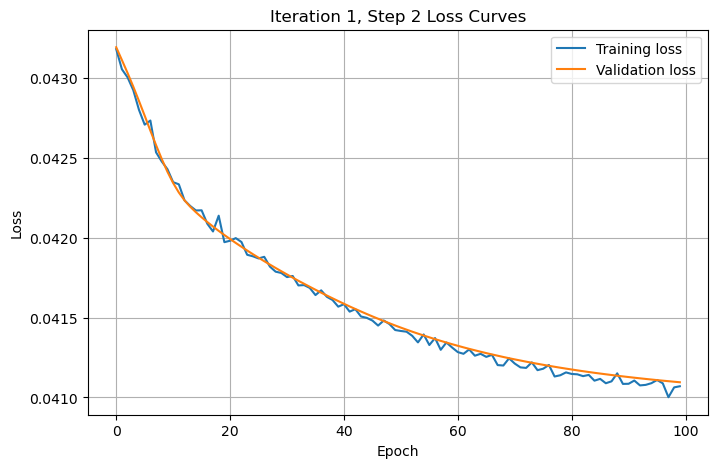

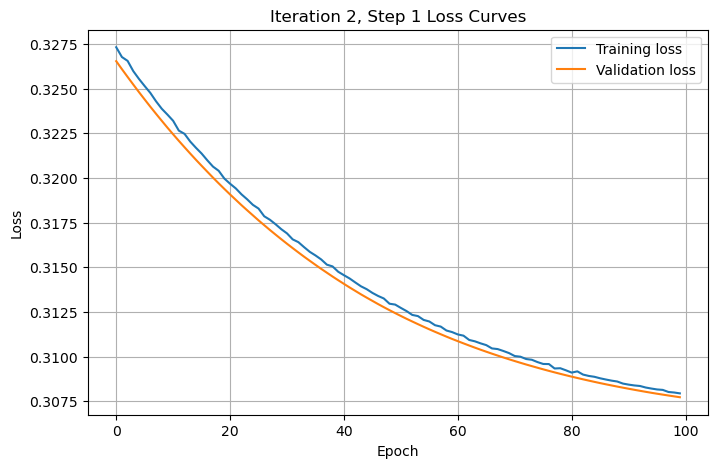

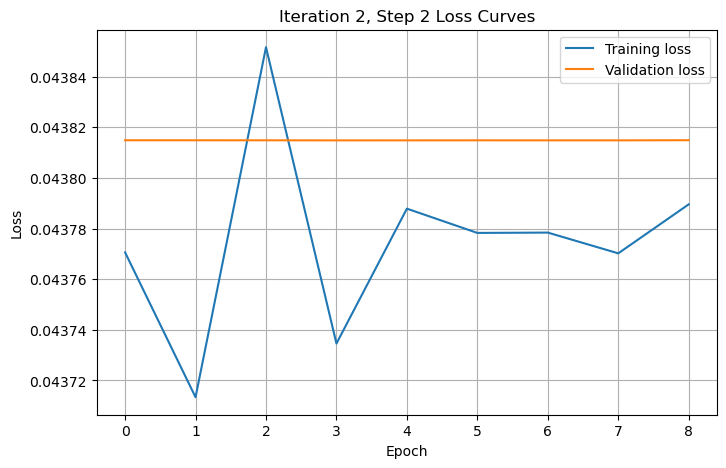

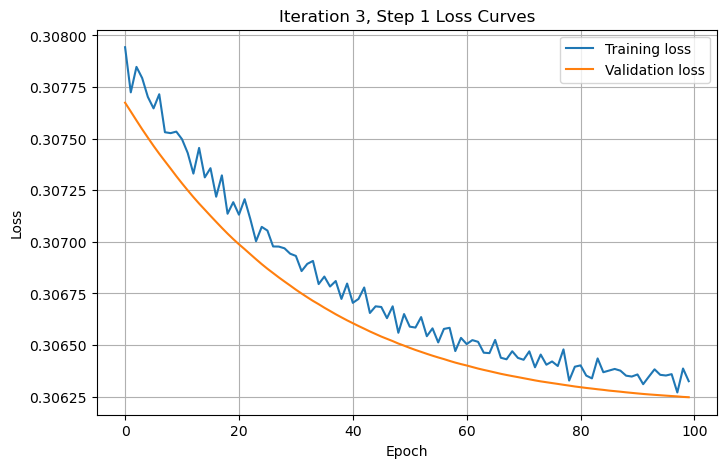

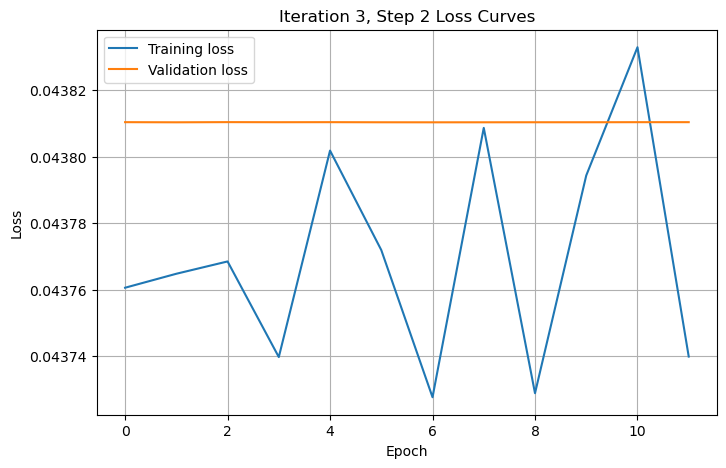

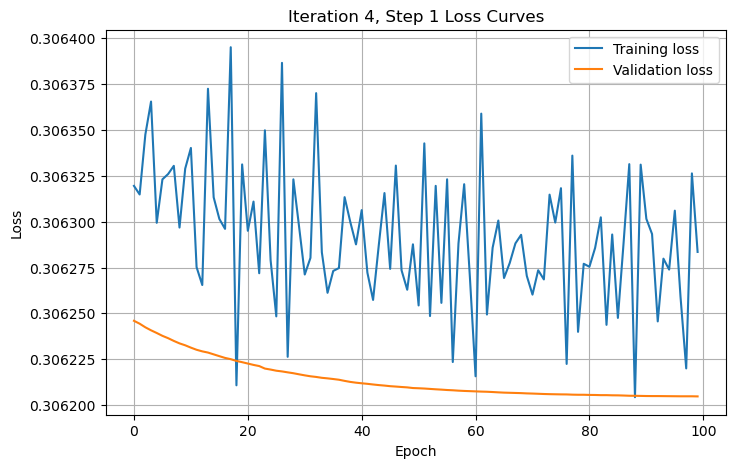

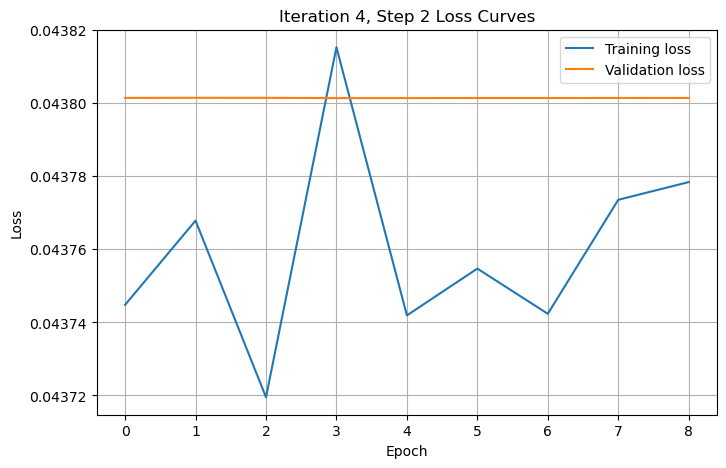

In [21]:
import pickle
import os
# Set these to your parameters
weights_folder = '/scratch/mjosef/Unfolding/omnifold/weights_real-data'      
name = "WWbb_transformer_real-data"     
niter = 4                       
n_ensemble = 1                  
# Loop over iterations and steps
for iteration in range(niter):
    for stepn in [1, 2]:
        plt.figure(figsize=(8,5))
        plt.title(f"Iteration {iteration+1}, Step {stepn} Loss Curves")
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        
        all_loss = []
        all_val_loss = []

        for e in range(n_ensemble):
            # Construct pickle file name
            model_file = f"{weights_folder}/OmniFold_{name}_iter{iteration}_step{stepn}"
            if n_ensemble > 1:
                model_file += f"_ensemble{e}"
            model_file += ".weights.h5"
            history_file = model_file.replace(".weights.h5", ".pkl")
            
            # Load history
            if os.path.exists(history_file):
                with open(history_file, "rb") as f:
                    history = pickle.load(f)
                all_loss.append(history['loss'])
                all_val_loss.append(history['val_loss'])
            else:
                print(f"History file not found: {history_file}")

        # Average over ensembles if multiple
        avg_loss = np.mean(all_loss, axis=0)
        avg_val_loss = np.mean(all_val_loss, axis=0)

        plt.plot(avg_loss, label='Training loss')
        plt.plot(avg_val_loss, label='Validation loss')
        plt.legend()
        plt.grid(True)
        plt.show()


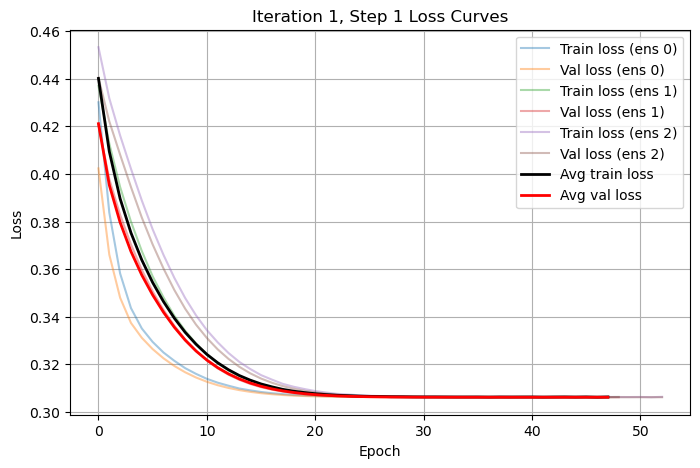

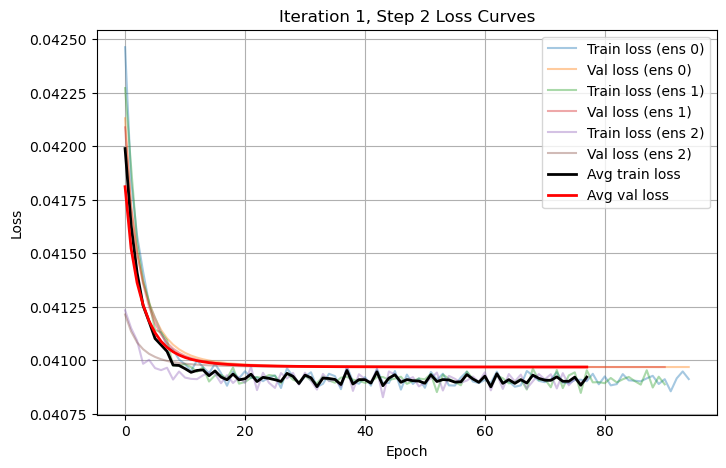

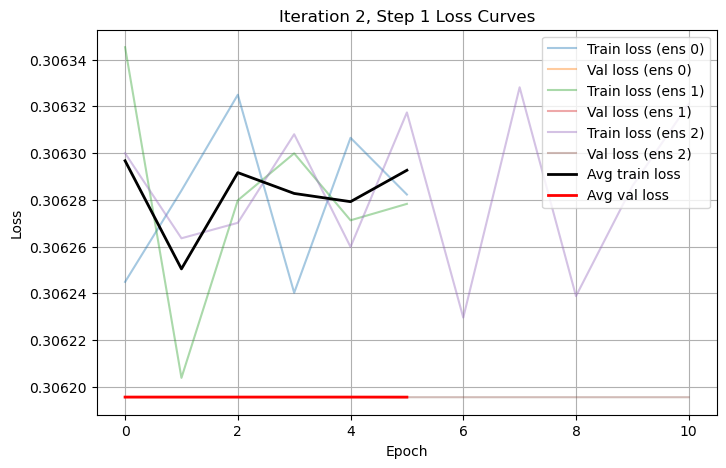

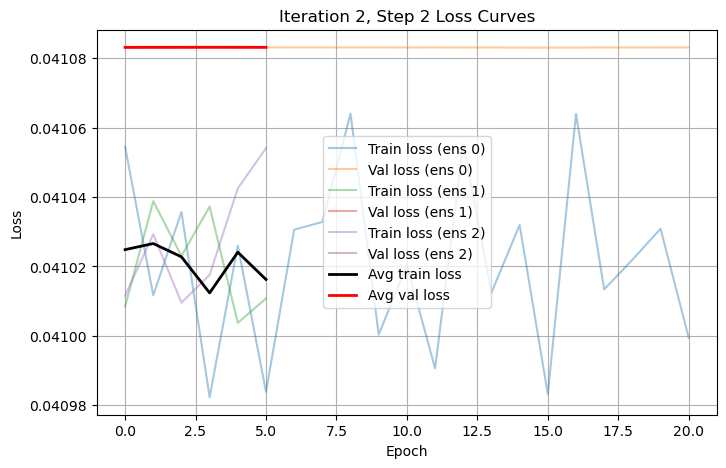

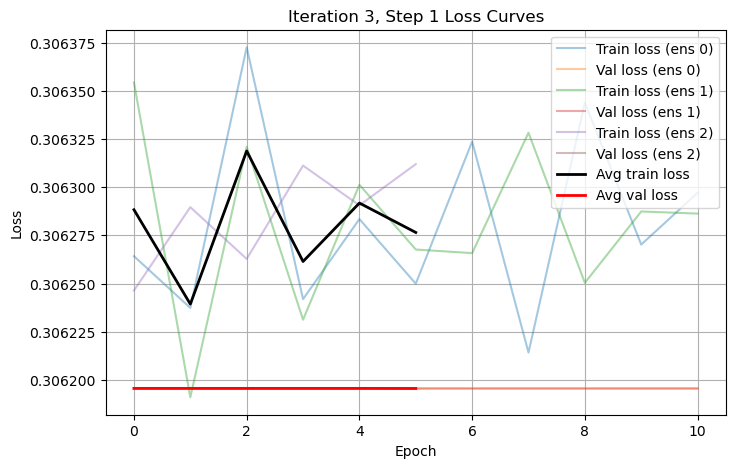

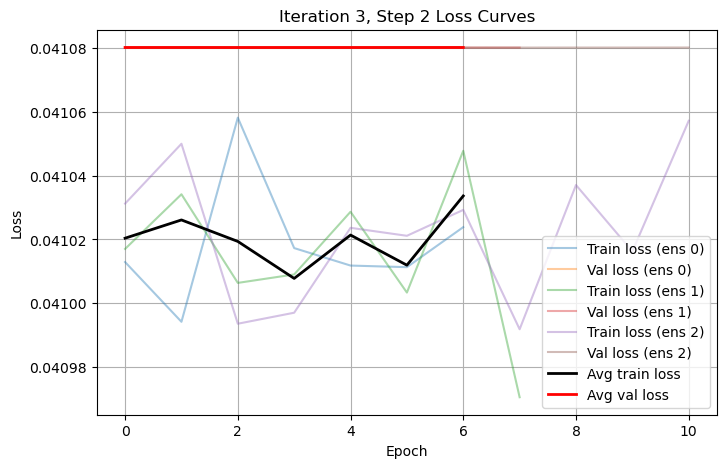

In [ ]:
import os
import pickle
import numpy as np
import matplotlib.pyplot as plt

weights_folder = '/scratch/mjosef/Unfolding/omnifold/weights_real-data'       
name = "WWbb_transformer_real-data"      
niter = 3                   
n_ensemble = 3                   

for iteration in range(niter):
    for stepn in [1, 2]:
        plt.figure(figsize=(8,5))
        plt.title(f"Iteration {iteration+1}, Step {stepn} Loss Curves")
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        
        all_loss = []
        all_val_loss = []

        for e in range(n_ensemble):
            model_file = f"{weights_folder}/OmniFold_{name}_iter{iteration}_step{stepn}_ensemble{e}.weights.h5"
            history_file = model_file.replace(".weights.h5", ".pkl")
            
            if os.path.exists(history_file):
                with open(history_file, "rb") as f:
                    history = pickle.load(f)
                all_loss.append(history['loss'])
                all_val_loss.append(history['val_loss'])
                
                # plot this ensemble individually
                plt.plot(history['loss'], alpha=0.4, label=f"Train loss (ens {e})")
                plt.plot(history['val_loss'], alpha=0.4, label=f"Val loss (ens {e})")
            else:
                print(f"History file not found: {history_file}")

        # ---- Optionally average (truncate to shortest) ----
        if all_loss:
            min_len = min(len(l) for l in all_loss)
            all_loss = [l[:min_len] for l in all_loss]
            all_val_loss = [l[:min_len] for l in all_val_loss]
            
            avg_loss = np.mean(all_loss, axis=0)
            avg_val_loss = np.mean(all_val_loss, axis=0)

            plt.plot(avg_loss, color='black', lw=2, label="Avg train loss")
            plt.plot(avg_val_loss, color='red', lw=2, label="Avg val loss")

        plt.legend()
        plt.grid(True)
        plt.show()

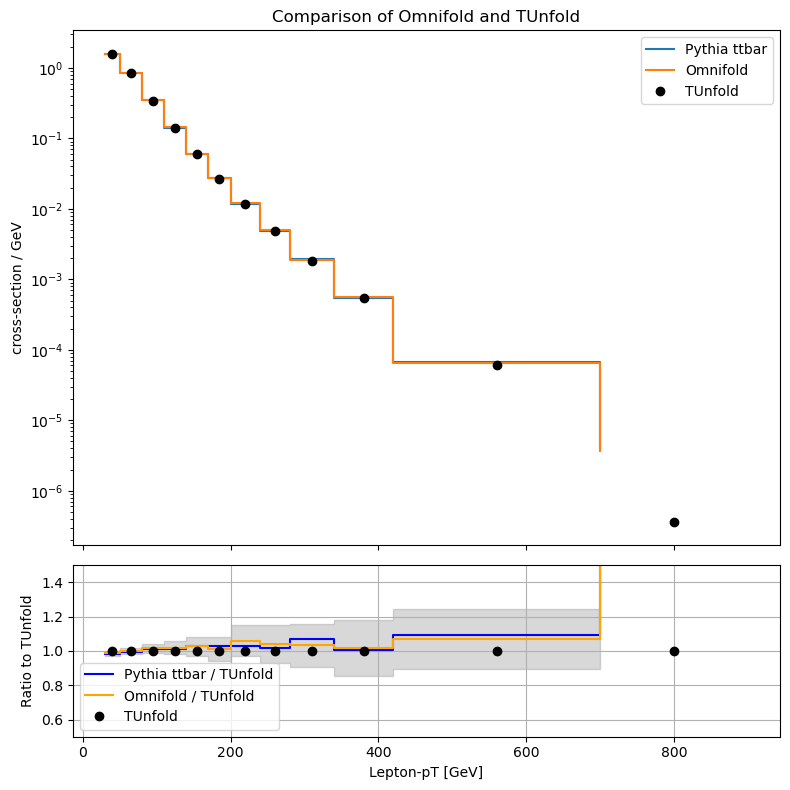

In [35]:
hist = TUnfold_incl_file['unfolding_ptl1_NOSYS']
values = hist.values()
edges = hist.axis().edges()

luminosity = 3244.54 + 33402.2 + 44630.6 + 58791.6
SF = (1/luminosity)*1/train_fraction
bin_widths = np.diff(edges)


weights_omnifold = (unfolded_weights * pythia_weights_test)[pythia_pass_gen_test & flags_mc] * SF
weights_omnifold2 = weights_omnifold**2
values_omnifold = pythia_truth_test[:,0,0][pythia_pass_gen_test & flags_mc]

# Histogram Omnifold
counts2, _ = np.histogram(values_omnifold, bins=edges, weights=weights_omnifold)
counts2_density = counts2 / bin_widths

# relative Unsicherheit pro Bin für Omnifold
sum_w2, _ = np.histogram(values_omnifold, bins=edges, weights=weights_omnifold2)
counts2 = counts2.astype(float)
sum_w2 = sum_w2.astype(float)

with np.errstate(divide='ignore', invalid='ignore'):
    rel_unc_omnifold = np.sqrt(sum_w2) / counts2
    rel_unc_omnifold[~np.isfinite(rel_unc_omnifold)] = 0

fig, (ax1, ax2) = plt.subplots(
    2, 1, 
    figsize=(8, 8), 
    gridspec_kw={'height_ratios': [3, 1]}, 
    sharex=True
)

# --- Bin widths (same for all histograms) ---


# --- Upper panel: your histograms ---
counts1, bins1, _ = ax1.hist(
    pythia_loader.gen[:,0,0][pythia_loader.pass_gen], 
    weights=pythia_loader.weight[pythia_loader.pass_gen]*SF, 
    bins=edges, 
    histtype='step', 
    label='Pythia ttbar'
)
counts2, bins2, _ = ax1.hist(
    pythia_truth_test[:, 0, 0][pythia_pass_gen_test], 
    weights=(unfolded_weights * pythia_weights_test)[pythia_pass_gen_test] * SF, 
    bins=edges, 
    histtype='step', 
    label='Omnifold'
)
bin_centers = 0.5 * (edges[:-1] + edges[1:])
# Normalize counts by bin width
counts1_density = counts1 / bin_widths
counts2_density = counts2 / bin_widths
values_density = values / bin_widths

# Re-plot them stepwise
ax1.cla()
ax1.step(edges[:-1], counts1_density, where="post", label="Pythia ttbar")
ax1.step(edges[:-1], counts2_density, where="post", label="Omnifold")
ax1.plot(bin_centers, values_density, 'o', color='black', label='TUnfold')

ax1.set_ylabel("cross-section / GeV")
ax1.set_title("Comparison of Omnifold and TUnfold")
ax1.legend()
ax1.set_yscale('log')

# --- Lower panel: ratio ---
# Avoid division by zero
ratio1 = np.divide(counts1_density, values_density, out=np.zeros_like(counts1_density), where=values_density!=0)
ratio2 = np.divide(counts2_density, values_density, out=np.zeros_like(counts2_density), where=values_density!=0)
ratio3 = np.ones_like(values_density)  # TUnfold / TUnfold

# Step style ratios
ratio1_step = np.append(ratio1, ratio1[-1])
ratio2_step = np.append(ratio2, ratio2[-1])

upper = ratio2 * (1 + rel_unc_omnifold)
lower = ratio2 * (1 - rel_unc_omnifold)

ax2.step(edges, ratio1_step, where="post", color="blue", label="Pythia ttbar / TUnfold")
ax2.step(edges, ratio2_step, where="post", color="orange", label="Omnifold / TUnfold")
ax2.plot(bin_centers, ratio3, 'o', color='black', label='TUnfold')
ax2.fill_between(
    edges[:-1],
    lower,
    upper,
    step='post',
    alpha=0.3,
    color='grey'
)
#ax2.axhline(1.0, color='red', linestyle='--')

ax2.set_xlabel("Lepton-pT [GeV]")
ax2.set_ylabel("Ratio to TUnfold")
ax2.set_ylim(0.5, 1.5)
ax2.legend()
ax2.grid()

plt.tight_layout()
plt.show()

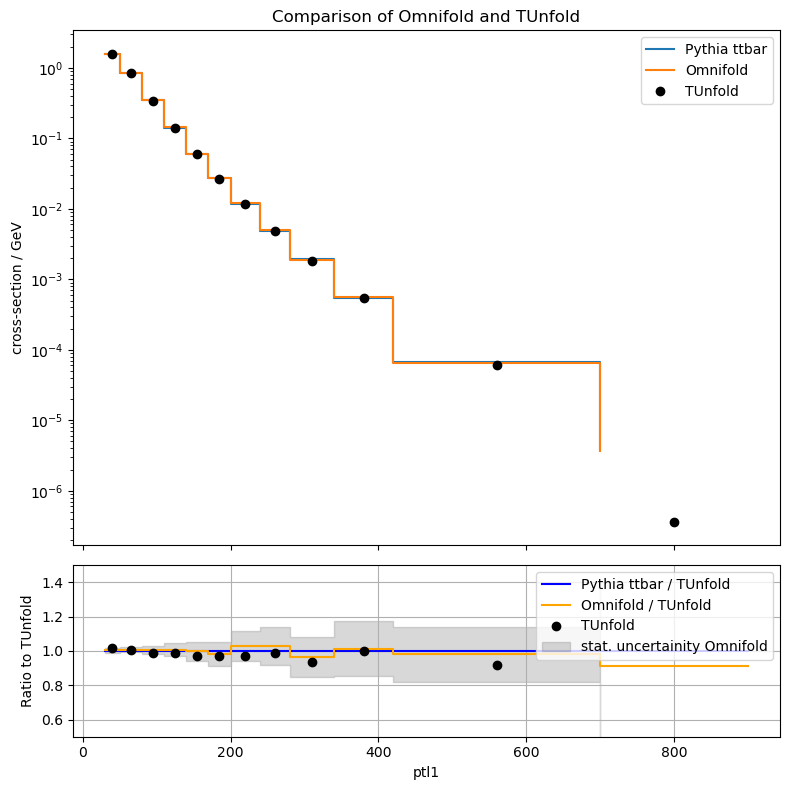

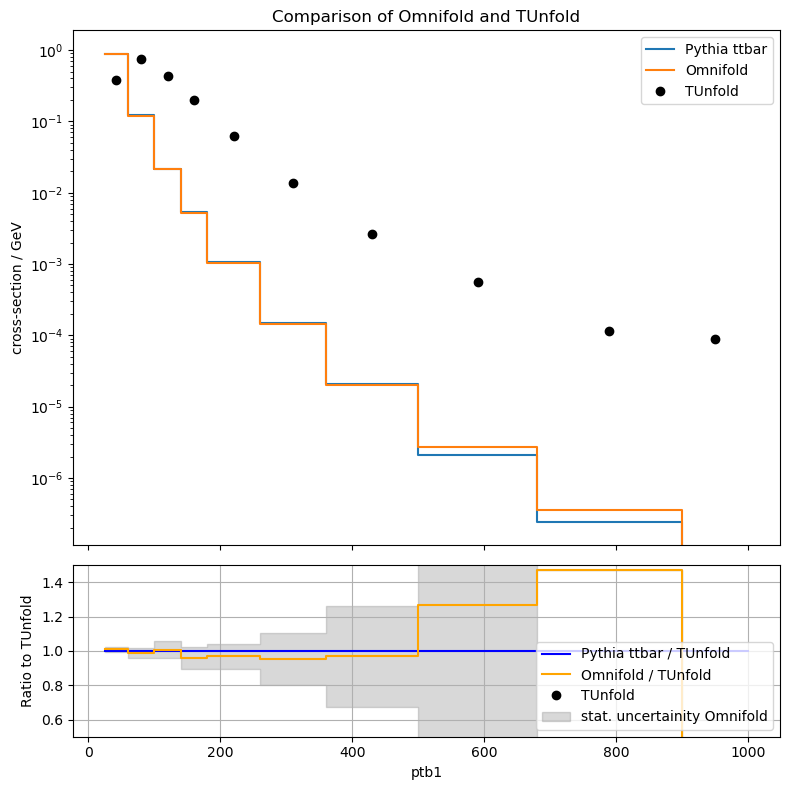

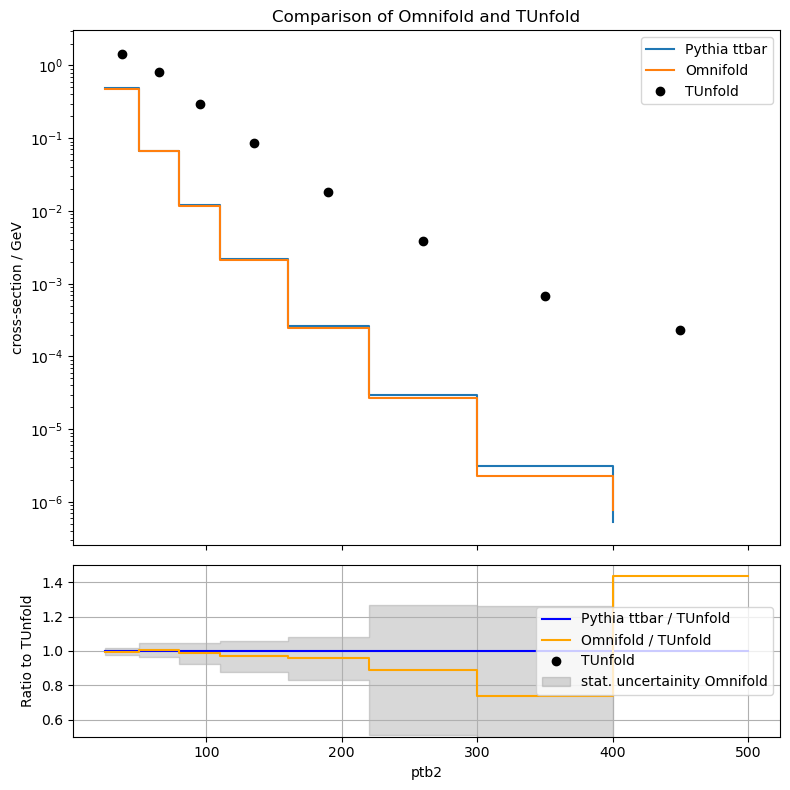

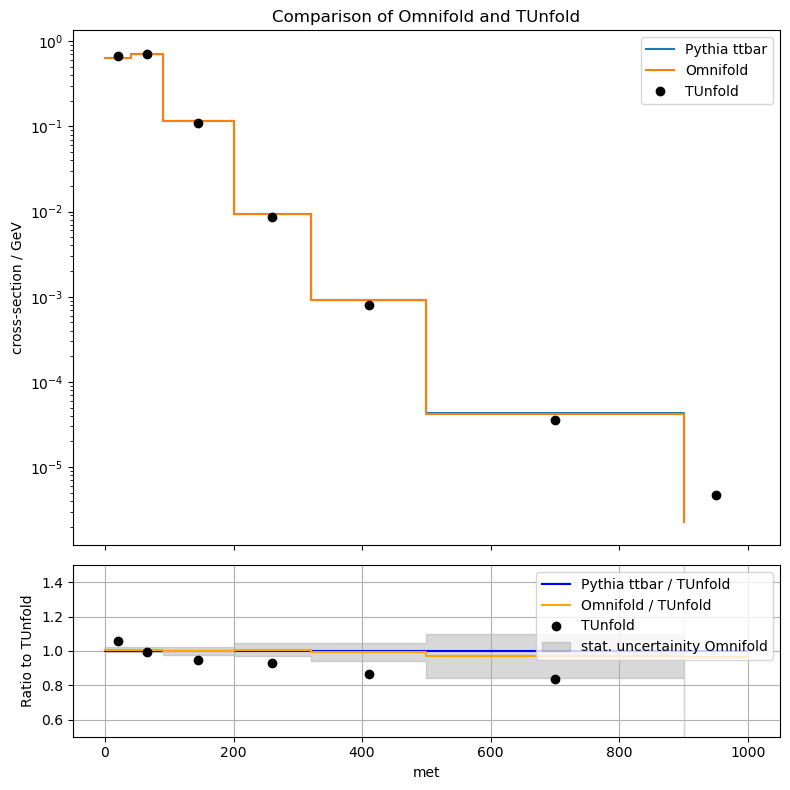

In [38]:
luminosity = 3244.54 + 33402.2 + 44630.6 + 58791.6
SF = (1/luminosity)*1/train_fraction

# -------------------------------
# Loop over all observables
# -------------------------------
observables = {
    "ptl1": 0,  # lepton pt
    #"ptj1": 1,
    #"ptj2": 2,
    #"ptj3": 3,
    #"ptj4": 4,
    #"ptj5": 5,
    #"ptj6": 6,
    "ptb1": 7,
    "ptb2": 8,
    #"ptb3": 9,
    #"ptb4": 10,
    "met":  11,
}
for obs_name, obs_index in observables.items():

    hist = TUnfold_incl_file[f'unfolding_{obs_name}_NOSYS']
    values = hist.values()
    edges = hist.axis().edges()
    bin_widths = np.diff(edges)
    bin_centers = 0.5 * (edges[:-1] + edges[1:])

    weights_omnifold = (unfolded_weights * pythia_weights_test)[pythia_pass_gen_test & flags_mc] * SF
    weights_omnifold2 = weights_omnifold**2
    values_omnifold = pythia_truth_test[:,obs_index,0][pythia_pass_gen_test & flags_mc]

    # Histogram Omnifold
    counts2, _ = np.histogram(values_omnifold, bins=edges, weights=weights_omnifold)
    counts2_density = counts2 / bin_widths

    # relative Unsicherheit pro Bin für Omnifold
    sum_w2, _ = np.histogram(values_omnifold, bins=edges, weights=weights_omnifold2)
    counts2 = counts2.astype(float)
    sum_w2 = sum_w2.astype(float)

    with np.errstate(divide='ignore', invalid='ignore'):
        rel_unc_omnifold = np.sqrt(sum_w2) / counts2
        rel_unc_omnifold[~np.isfinite(rel_unc_omnifold)] = 0

    fig, (ax1, ax2) = plt.subplots(
        2, 1, 
        figsize=(8, 8), 
        gridspec_kw={'height_ratios': [3, 1]}, 
        sharex=True
    )

    # --- Upper panel: your histograms ---
    counts1, bins1, _ = ax1.hist(
        pythia_loader.gen[:,obs_index,0][pythia_loader.pass_gen], 
        weights=pythia_loader.weight[pythia_loader.pass_gen]*SF, 
        bins=edges, 
        histtype='step', 
        label='Pythia ttbar'
    )
    counts2, bins2, _ = ax1.hist(
        pythia_truth_test[:, obs_index, 0][pythia_pass_gen_test], 
        weights=(unfolded_weights * pythia_weights_test)[pythia_pass_gen_test] * SF, 
        bins=edges,   
        histtype='step', 
        label='Omnifold'
    )
    bin_centers = 0.5 * (edges[:-1] + edges[1:])
    # Normalize counts by bin width
    counts1_density = counts1 / bin_widths
    counts2_density = counts2 / bin_widths
    values_density = values / bin_widths

    # Re-plot them stepwise
    ax1.cla()
    ax1.step(edges[:-1], counts1_density, where="post", label="Pythia ttbar")
    ax1.step(edges[:-1], counts2_density, where="post", label="Omnifold")
    ax1.plot(bin_centers, values_density, 'o', color='black', label='TUnfold')

    ax1.set_ylabel("cross-section / GeV")
    ax1.set_title("Comparison of Omnifold and TUnfold")
    ax1.set_yscale('log')
    ax1.legend()

    # --- Lower panel: ratio ---
    # Avoid division by zero
    ratio1 = np.divide(values_density, counts1_density, out=np.zeros_like(values_density), where=counts1_density!=0)
    ratio2 = np.divide(counts2_density, counts1_density, out=np.zeros_like(counts2_density), where=counts1_density!=0)
    ratio3 = np.ones_like(counts1_density)  # TUnfold / TUnfold

    # Step style ratios
    ratio1_step = np.append(ratio1, ratio1[-1])
    ratio2_step = np.append(ratio2, ratio2[-1])
    ratio3_step = np.append(ratio3, ratio3[-1])

    upper = ratio2 * (1 + rel_unc_omnifold)
    lower = ratio2 * (1 - rel_unc_omnifold)

    ax2.step(edges, ratio3_step, where="post", color="blue", label="Pythia ttbar / TUnfold")
    ax2.step(edges, ratio2_step, where="post", color="orange", label="Omnifold / TUnfold")
    ax2.plot(bin_centers, ratio1, 'o', color='black', label='TUnfold')
    ax2.fill_between(
        edges[:-1],
        lower,
        upper,
        step='post',
        alpha=0.3,
        color='grey',
        label='stat. uncertainity Omnifold'
    )
    #ax2.axhline(1.0, color='red', linestyle='--')

    ax2.set_xlabel(obs_name)
    ax2.set_ylabel("Ratio to TUnfold")
    ax2.set_ylim(0.5, 1.5)
    ax2.legend()
    ax2.grid()

    plt.tight_layout()
    plt.show()

## Does ttbar sample (without background) agree with ptb1 unfolded with TUnfold?

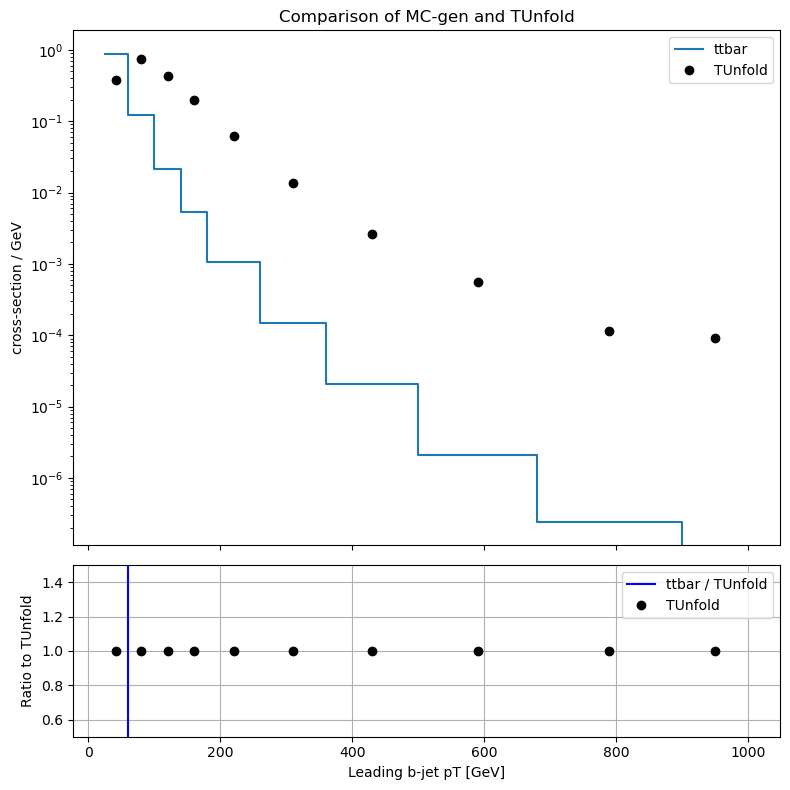

In [39]:
luminosity = 3244.54 + 33402.2 + 44630.6 + 58791.6
SF = (1/luminosity)*1/train_fraction

hist = TUnfold_incl_file[f'unfolding_ptb1_NOSYS']
values = hist.values()
edges = hist.axis().edges()
bin_widths = np.diff(edges)
bin_centers = 0.5 * (edges[:-1] + edges[1:])


fig, (ax1, ax2) = plt.subplots(
    2, 1, 
    figsize=(8, 8), 
    gridspec_kw={'height_ratios': [3, 1]}, 
    sharex=True
)

# --- Upper panel: your histograms ---
counts1, bins1, _ = ax1.hist(
    pythia_loader.gen[:, 7, 0][pythia_loader.pass_gen], 
    weights=pythia_loader.weight[pythia_loader.pass_gen]*SF, 
    bins=edges, 
    histtype='step', 
    label='ttbar'
)

# Normalize counts by bin width
counts1_density = counts1 / bin_widths
values_density = values / bin_widths
bin_centers = 0.5 * (edges[:-1] + edges[1:])
# Re-plot them stepwise
ax1.cla()
ax1.step(edges[:-1], counts1_density, where="post", label="ttbar")
ax1.plot(bin_centers, values_density, 'o', color='black', label='TUnfold')
#ax1.step(edges[:-1], values_density, where="post", label="TUnfold")

ax1.set_ylabel("cross-section / GeV")
ax1.set_title("Comparison of MC-gen and TUnfold")
ax1.legend()
ax1.set_yscale('log')

# --- Lower panel: ratio ---
# Avoid division by zero
ratio1 = np.divide(counts1_density, values_density, out=np.zeros_like(counts1_density), where=values_density!=0)
ratio3 = np.ones_like(values_density)  # TUnfold / TUnfold



# Step style ratios
ratio1_step = np.append(ratio1, ratio1[-1])

ax2.step(edges, ratio1_step, where="post", color="blue", label="ttbar / TUnfold")
ax2.plot(bin_centers, ratio3, 'o', color='black', label='TUnfold')

#ax2.axhline(1.0, color='red', linestyle='--')

ax2.set_xlabel("Leading b-jet pT [GeV]")
ax2.set_ylabel("Ratio to TUnfold")
ax2.set_ylim(0.5, 1.5)
ax2.legend()
ax2.grid()

plt.tight_layout()
plt.show()